## Install diffusers library

In [ ]:
!pip install git+https://github.com/huggingface/diffusers.git
!python3 -m pip install --no-cache-dir accelerate datasets hf-doc-builder huggingface-hub Jinja2 librosa numpy scipy tensorboard transformers 

## Add accelerate config

___
In this case I had some problems with the use of accelerate in colab as in the free account you cannot acces the shell and thus cannot finalize with the process. 
___

In [141]:
!accelerate config

## Training on a custom dataset

The dataset was obtained from the huggingface-hub

The prompt will generate an image that latter can be used to measure distance.

In [3]:
!export MODEL_NAME="CompVis/stable-diffusion-v1-4"
!export dataset_name="lambdalabs/pokemon-blip-captions"

!accelerate launch train_text_to_image.py --pretrained_model_name_or_path=$MODEL_NAME --dataset_name=$dataset_name --use_ema --resolution=512 --center_crop --random_flip --train_batch_size=1 --gradient_accumulation_steps=4 --gradient_checkpointing --mixed_precision="fp16" --max_train_steps=15000 --learning_rate=1e-05 --max_grad_norm=1 --lr_scheduler="constant" --lr_warmup_steps=0 --output_dir="sd-pokemon-model" 

/home/abetatos/Escritorio/Repositories/training/Stable diffusion based retrieval/venv/bin/python3: can't open file '/home/abetatos/Escritorio/Repositories/training/Stable diffusion based retrieval/train_text_to_image.py': [Errno 2] No such file or directory
Traceback (most recent call last):
  File "/home/abetatos/Escritorio/Repositories/training/Stable diffusion based retrieval/venv/bin/accelerate", line 10, in <module>
    sys.exit(main())
  File "/home/abetatos/Escritorio/Repositories/training/Stable diffusion based retrieval/venv/lib/python3.10/site-packages/accelerate/commands/accelerate_cli.py", line 47, in main
    args.func(args)
  File "/home/abetatos/Escritorio/Repositories/training/Stable diffusion based retrieval/venv/lib/python3.10/site-packages/accelerate/commands/launch.py", line 994, in launch_command
    simple_launcher(args)
  File "/home/abetatos/Escritorio/Repositories/training/Stable diffusion based retrieval/venv/lib/python3.10/site-packages/accelerate/commands/la

# Predicting the output

In [ ]:
from diffusers import StableDiffusionPipeline
import torch
import numpy as np

model_path = "sd-pokemon-model"
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)
pipe.unet.load_attn_procs(model_path)
pipe.to("cuda")

___
The generated image will be closer to the prompt "a drawing of a green pokemon with red eyes"
___


In [ ]:

prompt = "a drawing of a green pokemon with red eyes"
image = pipe(prompt, num_inference_steps=30, guidance_scale=7.5).images[0]
image.save("pokemon.png")

## Extracting features

I usedd a pretrained model to extract features from the image using a CNN.

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

original_model = models.alexnet(pretrained=True)

class AlexNetConv4(nn.Module):
            def __init__(self):
                super(AlexNetConv4, self).__init__()
                self.features = nn.Sequential(
                    # stop at conv4
                    *list(original_model.features.children())[:-3]
                )
            def forward(self, x):
                x = self.features(x)
                return x

model = AlexNetConv4()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

## Similarity

___
Here we apply the initialized model to a given image in order to generate the features. A simple metric is used to evaluate the similarity.
___

In [ ]:
from datasets import load_dataset


dataset = load_dataset("lambdalabs/pokemon-blip-captions")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/lambdalabs___parquet/lambdalabs--pokemon-blip-captions-10e3527a764857bd/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
def get_features(images, int_): 
  image = images[int_].resize([64, 64])
  display(image)

  array = np.array(image)
  torch_tensor = torch.tensor(array, dtype=torch.float32)
  torch_tensor = torch_tensor.permute(2, 1, 0)[None, :, :] # To fit channels

  return model.forward(torch_tensor)

___
The accelerate problems did not permit to generate the output file. If possible the generated image by the finetuned stable diffusion model can be used.
___

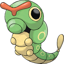

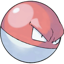

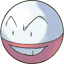

In [ ]:
images = dataset['train']['image']
output1 = get_features(images, 1)
output2 = get_features(images, 2)
output3 = get_features(images, 3)

___
Simple metric that computes a distance. More complex functions can be used
___

In [138]:
distance = lambda tensor1, tensor2: (tensor1 - tensor2).pow(2).sum(3).sum(2).sum(1).sqrt().item()

In [139]:
distance(output1, output2)

7643.5908203125

In [ ]:
distance(output1, output3)

8248.5830078125

In [140]:
distance(output2, output3)

6428.525390625

___
Images 2 and 3 are the closer ones, and it makes sense since Electrode is the evolution of Voltorb. This process could be automated to obtain distance for a complete dataset. 
___